# **<font color=#FF3399> Gabarito Challenge Modelos Regressivos </font>**

Bootcamp Data Analytics & Tech Minas 2023 

WoMakersCode


In [1]:
#### Importando os pacotes que serao utilizados nos dois desafios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt ## graficos
import seaborn as sns ## graficos
from scipy.stats import skewnorm ## Gerar distribuicoes assimétricas, etc (utilizado na montagem do dataset)
from google.colab import drive ## conectar com o google drive para ler seus arquivos
import statsmodels.api as sm ## para rodar a regressao
from sklearn.model_selection import train_test_split ## separando treino e teste
from sklearn.feature_selection import RFE ## selecao de features
from sklearn import  linear_model ## para rodar a regressao (outra possibilidade)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive



## **<font color=#FF3399> Desafio: Imóveis </font>**

**Contexto:**
Suponha que você trabalha em uma empresa do setor imobiliário. Após explorar as principais variáveis que impactam o preco dos imóveis,na semana passada, pediram para você, do time de dados, construir um modelo que estime o preço de um imóvel. Para isso, você utilizará a mesma base de dados da semana anterior (desafio_01_preco_imoveis.csv). Como você poderia ajudá-los?


### 1: Selecione as principais variáveis que você gostaria de incluir no modelo de precificação do imóvel. 



In [3]:
### Antes de comecarmos a responder as perguntas vamos ler a base disponibilizada.

df = pd.read_csv("/content/drive/MyDrive/WoMakers/BOOTCAMP/Desafios/desafio_01_preco_imoveis.csv")

Primeiro vamos separar amostra de treino e teste aleatóriamente (Out of sample), sendo 20% teste e 80% treino.

vamos retir as variáveis ID e Date nesse caso, pois nesse caso nao fazem muito sentido do ponto de vista de negócio. Porém, Data poderia ser utilizada com duas possíveis formas:
  - como proxy para inflação. Sabemos que o preço dos imóveis oscila com o tempo e devido à inflação. 
  - como forma de separar a nossa base de treino e teste. Ao invés de separarmos 80% treino e 20% teste poderíamos ter separado " out of time". Nesse caso, a partir de certo período poderíamos considerar como teste e anterior a ele como treino

Para fins de simplificação, optamos aqui por retirar essa variável do modelo

In [4]:
#### Vamos construir um dataframe X com as variáveis explicativas possíveis
X = df[[ 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long']].copy()
#### temos uma pandas series com a variável target, que queremos explicar
y = df["price"]

#### vamos fazer o split deixando 20% para teste e 80% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para selecionar as variáveis que vamos utilizar nos modelos podemos fazer de diferentes formas.
- Podemos analisar a correlação e:
  - dropar variáveis com correlações muito altas ( por exemplo : na casa de 0.9) para evitar multicolinearidade.
  - manter variáveis com bom nível de correlação

- Podemos selecionar as features de modo:

  1. Recursivo (recursive feature elimination), roda modelos iterativamente da seguinte forma:
    - passamos quantas variáveis explicativas queremos manter. Ex: 10, pois esse seria o grau de complexidade do modelo que estamos dispostos a tolerar e o algoritmo seleciona automaticamente as features que possuem maior relevancia para o modelo (maiores betas e p valor < 0.05)

  2. Stepwise:
    - começa rodando o modelo com todas as variáveis e vai iterativamente eliminando variáveis nao significativas (p valor < nivel de significancia desejado , ex: 0.05 ) até estabilizar em um modelo final
    - stepwise forward: começa rodando o modelo com 1 feature e vai adicionando iterativamente somente as features que possuem o nível de significancia desejado até estabilizar o modelo final.


Neste gabarito, vamos mostrar como rodar a seleção de features de modo recursivo e com stepwise forward.



In [ ]:
### SELECAO DE VARIAVEIS UTILIZANDO ELIMINACAO RECURSIVA (1)

### criamos uma variável modelo
model = linear_model.LinearRegression()

## chamamos a função RFE (recursive feature elimination) e passamos como parametro quantas features desejamos selecionar
rfe = RFE(estimator=model, n_features_to_select=10)
## treinamos o modelo
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=10)

In [ ]:
from operator import itemgetter
### vamos printar a baixo o resultado do RFE
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 bedrooms
1 bathrooms
1 floors
1 waterfront
1 view
1 condition
1 grade
1 yr_built
1 lat
1 long
2 sqft_living
3 sqft_above
4 sqft_basement
5 zipcode
6 yr_renovated
7 sqft_lot


Conclusão: utilizando a eliminacao de features recursiva, vimos que as principais variáveis que devemos incluir no modelo são as rankeadas em 1 lugar.

Podiamos também fazer uma análise utilizando a regressao stepwise ou step forward, como aplicado no seguinte exemplo: https://www.datasklr.com/ols-least-squares-regression/variable-selection

In [ ]:
#### Exemplo selecao de variaveis utilizando regressao stepwise to tipo forward.
def forward_regression(X, y,
                       initial_list=[], 
                       threshold_in=0.01,
                       verbose=True):
    '''
    X -> variáveis explicativas de treino
    y -> variável target de treino
    threshold_in -> limite desejado para significancia estatistica (somente incluir variaveis com p-val < esse valor).

    '''

    initial_list = []
    included = list(initial_list)
    pval_list = []
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            # Change argmin -> idxmin
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            pval_list.append(best_pval)
            changed=True
            if verbose:
                print('Add {} with p-value {} '.format(best_feature, best_pval))

        if not changed:
            break

    return included, pval_list

In [ ]:
included, pval_list = forward_regression(X_train, y_train, threshold_in = 0.01)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Add grade with p-value 0.0 
Add lat with p-value 0.0 
Add waterfront with p-value 0.0 
Add sqft_living with p-value 0.0 
Add yr_built with p-value 0.0 
Add view with p-value 4.8231920950519854e-122 
Add bedrooms with p-value 1.1012703518958486e-35 
Add bathrooms with p-value 1.7201253172930236e-45 
Add zipcode with p-value 2.429391646026267e-33 
Add long with p-value 3.6774373342948627e-35 
Add sqft_basement with p-value 6.042175246362968e-14 
Add sqft_above with p-value 3.4009624413202294e-231 
Add condition with p-value 4.4642300205845114e-17 
Add yr_renovated with p-value 1.8713508058533327e-06 


Pelo exemplo acima, mais detalhado no link, conseguimos ver quais variáveis foram adicionadas no modelo final a cada iteraçao. Note que todas elas possuem p valor < do que o threshold_in de 0.01 que colocamos, que seria dado o nível de significancia

### 2. Construa um modelo de regressão linear multivariada para estimar o preço do imóvel.  Lembre-se de: Analisar a tabela de regressão e os resíduos do modelo e interprete os resultados


In [ ]:
### Utilizando somente as variaveis explicativas selecionadas

X = df[['bedrooms', 'bathrooms','waterfront', 'view', 'condition', 'grade', 'yr_built','lat', 'long']].copy() 
## no X podemos incluir somentre as features selecionadas, seja com RFE ou regressao Stepwise e podemos testar iterativamente.
y = np.log(df['price']) ## utilizamos o log no preço para a escala ser compativel com a das variáveis explicativas, aqui o log funciona como uma padronizacao

In [ ]:
### separando as bases de treino e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
### treinnado o modelo
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
!pip install regressors

In [ ]:
#### Analisando os resultados da tabela de regressao.
from regressors import stats
print("\n=========== SUMMARY ===========")
xlabels = X.columns
stats.summary(model, X, y, xlabels)


=========== SUMMARY ===========
Residuals:
     Min       1Q  Median      3Q     Max
-1.45690 -0.16590 0.00410 0.17110 1.45250


Coefficients:
            Estimate  Std. Error    t value  p value
_intercept -23.64419     1.90470  -12.41360  0.00000
bedrooms     0.02603     0.00225   11.59580  0.00000
bathrooms    0.16507     0.00359   45.96020  0.00000
waterfront   0.40168     0.02326   17.27110  0.00000
view         0.08301     0.00257   32.35400  0.00000
condition    0.05457     0.00302   18.04330  0.00000
grade        0.24747     0.00204  121.39310  0.00000
yr_built    -0.00416     0.00001 -743.22750  0.00000
lat          1.35051     0.01252  107.91260  0.00000
long         0.17909     0.00295   60.75760  0.00000
---
R-squared:  0.73568,    Adjusted R-squared:  0.73557
F-statistic: 6680.87 on 9 features


Mesmo passando no RFE, floors nao apareceu como estatisticamente relevante entao a tiramos do modelo. Como o modelo, está com a variável target em log, a interpretação da tabela de regressao é:

- bedrooms: A cada 1 quarto a mais leva a 100*0.02603  aumento percentual no preço (2.6%)
- bathrooms : A cada 1 quarto a mais leva a 100*0.16507 aumento percentual no preço (16.507%)
... e assim por diante .

Logo, as variáveis de maior impacto são: A combinacao de latitude e longitude (localizacao / bairro do imovel), se o imóvel possui vista para o mar, a nota dele, e o número de banheiros

Apos aplicarmos qualquer padronizacao de metricas em nossos modelos precisamos entender que isso afeta a interpretabilidade dos betas. Abaixo temos a interpretacao dos parametros estimados no caso de um modelo sem logs (level -level) ; e modelos com logs.

Caso fosse feita a padronizacao de outra forma, ex: normalizacao, para interpretar os coeficientes estimados teriamos que fazer a função inversa da normalização para interpretar os coeficientes.

Entendendo a interpretação dos coeficientes quando utilizamos transformações logaritmicas: 

Dado isso vamos interpretar a tabela de regressao acima.

- A cada número de quartos adicionado por exemplo temos um coeficiente beta estimado de 0.026. Assim, como a nossa variável y foi padronizada em log. Esse coeficiente significa que a cada quarto a mais temos 100*0.026 = 2.6% de alteração no preço do imóvel

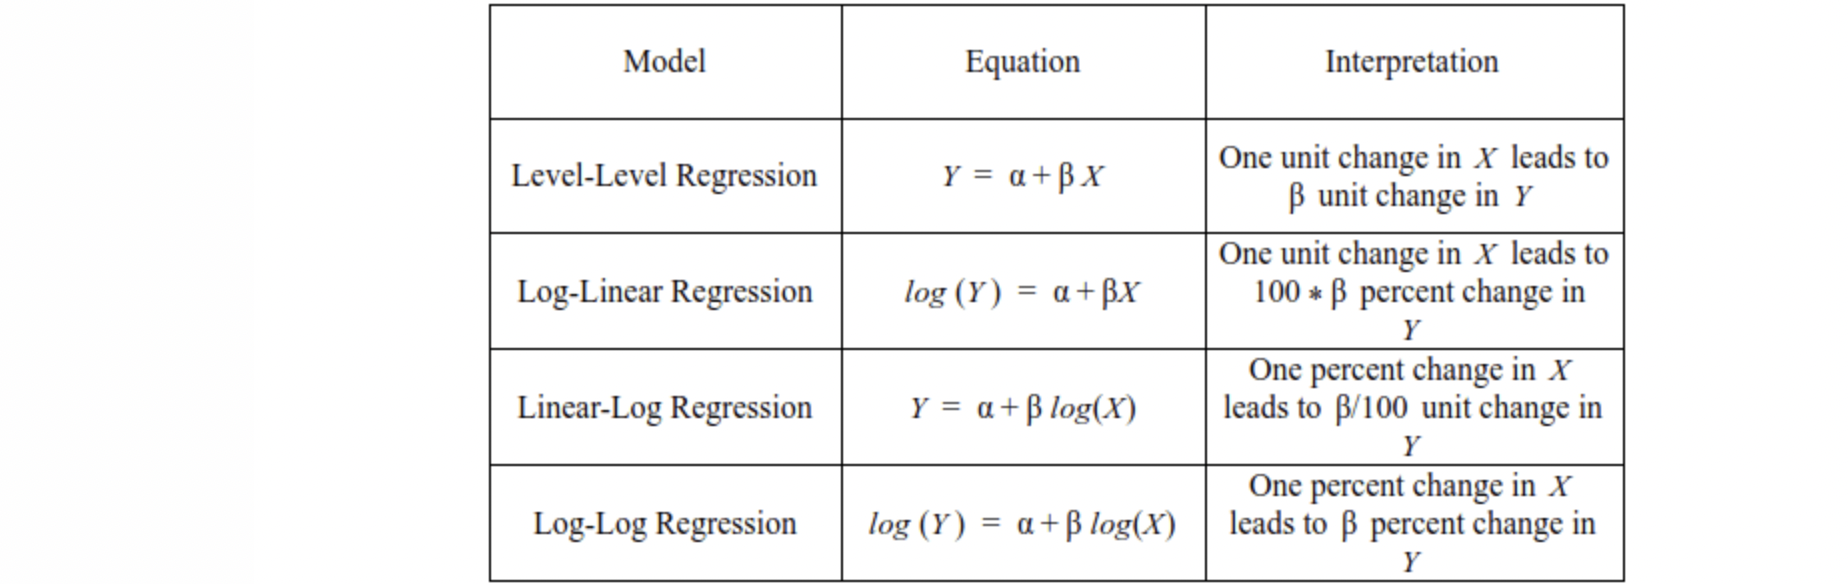

Prevendo o conjunto de teste para avaliação dos resultados e dos resíduos

In [ ]:
y_pred = model.predict(X_test)
residuo = (y_test - y_pred)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE 0.21061955768151946
MSE 0.0754606603041801
RMSE 0.27470103804714696


### Analise de Resíduos

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


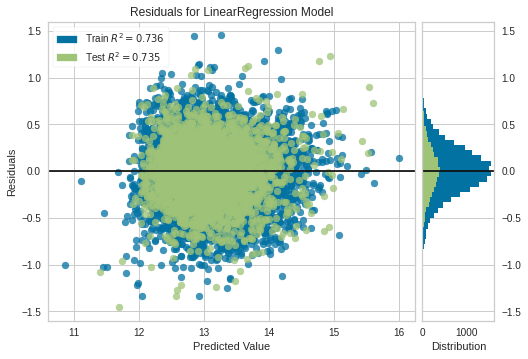

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train.values)  
visualizer.score(X_test, y_test.values)  
visualizer.show()   

Pelo gráfico acima podemos ver que os resíduos do modelo fitado parecem ter distribuição normal e parecem estar bem dispersos, o que é um bom compartamento

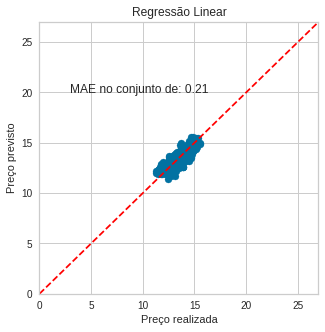

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
string_score = f"\nMAE no conjunto de: {mae:.2f}"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Regressão Linear")
plt.ylabel("Preço previsto")
plt.xlabel("Preço realizada")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

Pelo gráfico acima podemos ver que os preços previstos estao bem proximos dos preços realizados em teste, portante temos um outro indicativo de que temos um bom modelo

### 3 - Suponha agora que você encontrou um modelo ideal. Explique como você faria para colocar esse modelo em produção? Entenda por modelo em produção um modelo que a cada apartamento novo inserido na base precifique-o com base no seu modelo

Para precificar um novo a apartamento à medida que as variáveis: 'bedrooms', 'bathrooms','waterfront', 'view', 'condition', 'grade', 'yr_built','lat', 'long' são incluídas na base vamos seguir os passos abaixo:

1. Salvar o modelo em um arquivo binário (feito abaixo)

2. Criar um arquivo .py que faça o processo de limpeza e 
tratamento de variáveis. Vamos chamá-lo de model_handler.py. Esse arquivo será chamado antes do seu modelo rodar toda vez.

3. Criar uma aplicação utilizando flask ou serviços da AWS, como o sagemaker, em que leia um JSON com os inputs do modelo e retorne um json com o valor do preço. 

obs: lembrando que, como o modelo foi treinado com a target em log, vamos exponenciar o resultado do modelo (utilizar a função inversa) para obter o preço.

In [ ]:
### Exemplo do passo 1:
import pickle
# salvando o modelo em um arquivo binário
filename = './finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))

### Lendo o modelo salvo posteriormente
modelo_salvo = pickle.load(open(filename, 'rb'))
result = modelo_salvo.predict(X_test[:1])
print(result)

[12.96318401]
